### Takımımız:

21010708038 Mert Avcı \
20010708005 Enes Öztekin \
22110708001 Cihat Ali Yaman \
22300708001 Atahan Ak

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

In [2]:
from pyspark.sql.functions import rand

In [32]:
# SparkSession başlatma
spark = SparkSession.builder.appName("Team Alpha Big Data Project").getOrCreate()

In [4]:
# CSV dosyasını okuyoruz.
dataset = spark.read.csv('main_dataset.csv', header=True, inferSchema=True, encoding='UTF-8')

In [5]:
dataset.count()

43957

### Spark Pre-Processing

In [6]:
reduced_df = dataset.select("income_>50K", "gender", "age", "native-country", "relationship", "hours-per-week", "occupation", "education").orderBy(rand())

In [7]:
reduced_df.show()

+-----------+------+---+--------------+--------------+--------------+-----------------+------------+
|income_>50K|gender|age|native-country|  relationship|hours-per-week|       occupation|   education|
+-----------+------+---+--------------+--------------+--------------+-----------------+------------+
|          0|Female| 18| United-States|     Own-child|            24|             NULL|     HS-grad|
|          0|  Male| 68| United-States| Not-in-family|            15|    Other-service|     HS-grad|
|          1|  Male| 44| United-States|       Husband|            40|  Exec-managerial|   Bachelors|
|          0|  Male| 59| United-States| Not-in-family|             8|             NULL|  Assoc-acdm|
|          1|  Male| 61|         India|       Husband|            45|   Prof-specialty|     Masters|
|          0|  Male| 29| United-States|     Own-child|            23|            Sales|   Assoc-voc|
|          0|  Male| 56| United-States|       Husband|            40|Machine-op-inspct|    

In [8]:
from pyspark.sql.functions import col, isnan, when, count

# Her sütundaki NaN değerlerini kontrol etme
nan_exists_all = reduced_df.select(
    [(count(when(isnan(col(c)) | col(c).isNull(), c)) > 0).alias(c) for c in reduced_df.columns]
)

# Sonuçları gösterme
nan_exists_all.show()

+-----------+------+-----+--------------+------------+--------------+----------+---------+
|income_>50K|gender|  age|native-country|relationship|hours-per-week|occupation|education|
+-----------+------+-----+--------------+------------+--------------+----------+---------+
|      false| false|false|          true|       false|         false|      true|    false|
+-----------+------+-----+--------------+------------+--------------+----------+---------+



In [9]:
# Toplam satır sayısını al
total_rows = reduced_df.count()

# Her sütunun doluluk oranını hesapla
doluluk_orani = (
    reduced_df.select(
        [
            (count(when(col(c).isNotNull(), c)) / total_rows * 100).alias(c)
            for c in reduced_df.columns
        ]
    )
)

# Sonuçları gösterme
doluluk_orani.show()

+-----------+------+-----+-----------------+------------+--------------+-----------------+---------+
|income_>50K|gender|  age|   native-country|relationship|hours-per-week|       occupation|education|
+-----------+------+-----+-----------------+------------+--------------+-----------------+---------+
|      100.0| 100.0|100.0|98.26421275337262|       100.0|         100.0|94.29897399731556|    100.0|
+-----------+------+-----+-----------------+------------+--------------+-----------------+---------+



In [10]:
from pyspark.sql.functions import lit

# Toplam veri sayısı
total_data = reduced_df.count()

# Hedef doluluk oranı (%80)
target_fill_rate = 0.8
missing_count = int(total_data * (1 - target_fill_rate))  # Boş veri sayısı

# 'hours-per-week' sütunundaki eksik verileri eklemek
# Spark DataFrame'e eksik veriler eklemek için, yeni bir DataFrame oluşturup birleştirme işlemi yapabiliriz.
# Boş veri eklemek için NaN değerleri taşıyan yeni bir DataFrame oluşturuyoruz.

# Eksik veriler ile aynı sayıda satır oluştur
null_data = reduced_df.limit(missing_count).withColumn("hours-per-week", lit(None))

# Geriye kalan veriyi al
remaining_data = reduced_df.subtract(null_data)

# Eksik verilerle birlikte birleştir
final_df = remaining_data.union(null_data)

# Sonuçları görmek için
final_df.show()

+-----------+------+---+--------------------+--------------+--------------+-----------------+------------+
|income_>50K|gender|age|      native-country|  relationship|hours-per-week|       occupation|   education|
+-----------+------+---+--------------------+--------------+--------------+-----------------+------------+
|          0|Female| 18|       United-States|          Wife|            40|    Other-service|     HS-grad|
|          0|Female| 24|       United-States| Not-in-family|            36|Handlers-cleaners|     HS-grad|
|          1|  Male| 28|       United-States|       Husband|            50|  Exec-managerial|   Bachelors|
|          0|  Male| 50|       United-States|       Husband|            48|            Sales|     HS-grad|
|          0|  Male| 23|       United-States|Other-relative|            40|     Craft-repair|  Assoc-acdm|
|          1|Female| 39|       United-States|          Wife|            25|     Adm-clerical|  Assoc-acdm|
|          0|  Male| 42|         El-S

In [11]:
# Toplam satır sayısını al
total_rows = final_df.count()

# Her sütunun doluluk oranını hesapla
doluluk_orani = (
    final_df.select(
        [
            (count(when(col(c).isNotNull(), c)) / total_rows * 100).alias(c)
            for c in final_df.columns
        ]
    )
)

# Sonuçları gösterme
doluluk_orani.show()

+-----------+------+-----+-----------------+------------+-----------------+-----------------+---------+
|income_>50K|gender|  age|   native-country|relationship|   hours-per-week|       occupation|education|
+-----------+------+-----+-----------------+------------+-----------------+-----------------+---------+
|      100.0| 100.0|100.0|97.85024330016704|       100.0|78.71789285109061|93.85334204856319|    100.0|
+-----------+------+-----+-----------------+------------+-----------------+-----------------+---------+



<Figure size 1000x600 with 0 Axes>

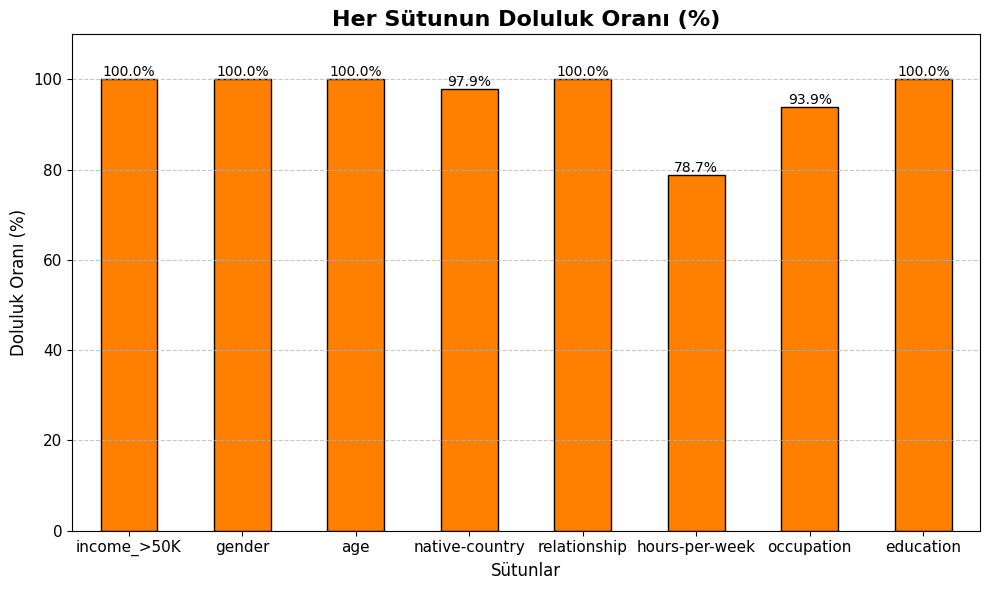

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Doluluk oranını pandas DataFrame'e dönüştürme
doluluk_orani_df = doluluk_orani.toPandas().T
doluluk_orani_df.columns = ['Doluluk Oranı (%)']
doluluk_orani_df.reset_index(inplace=True)
doluluk_orani_df.rename(columns={'index': 'Sütun'}, inplace=True)

# Çubuk grafik çizimi
plt.figure(figsize=(10, 6))
ax = doluluk_orani_df.plot(
    kind='bar', 
    x='Sütun', 
    y='Doluluk Oranı (%)', 
    color='#FF8000', 
    edgecolor='black', 
    legend=False, 
    figsize=(10, 6)
)

plt.title('Her Sütunun Doluluk Oranı (%)', fontsize=16, fontweight='bold')
plt.ylabel('Doluluk Oranı (%)', fontsize=12)
plt.xlabel('Sütunlar', fontsize=12)

plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Değerleri çubukların üzerinde gösterme
for index, row in doluluk_orani_df.iterrows():
    ax.text(index, row['Doluluk Oranı (%)'], f"{row['Doluluk Oranı (%)']:.1f}%", ha='center', va='bottom', fontsize=10)

plt.ylim(0, doluluk_orani_df['Doluluk Oranı (%)'].max() * 1.1)
plt.tight_layout()
plt.show()

In [13]:

# 'native-country' sütunundaki eksik değerleri 'Unknown' ile doldurma
final_df = final_df.fillna({"native-country": "Unknown"})

In [14]:
# Şimdi native-country sütunundaki boş değerleri "Unknown" ile doldurduk. Bu değerlerin dolup dolmadığını kontrol edelim.
nan_exists_native_country = final_df.select(
    (count(when(isnan(col("native-country")) | col("native-country").isNull(), "native-country")) > 0).alias("native-country")
)

# Sonuçları gösterme
nan_exists_native_country.show()

+--------------+
|native-country|
+--------------+
|         false|
+--------------+



In [15]:
from pyspark.sql.functions import mean, lit

# 'hours-per-week' sütununun ortalamasını hesaplıyoruz
hours_per_week_mean = final_df.select(mean("hours-per-week").alias("hours-per-week")).collect()[0]["hours-per-week"]

# 'hours-per-week' sütunundaki eksik değerleri ortalama ile doldurma
final_df = final_df.fillna({"hours-per-week": hours_per_week_mean})

In [16]:
# Şimdi hours-per-week sütunundaki boş değerleri o sütundaki değerlerin ortalaması ile doldurduk. Bu değerlerin dolup dolmadığını kontrol edelim.
nan_exists_hours_per_week = final_df.select(
    (count(when(isnan(col("hours-per-week")) | col("hours-per-week").isNull(), "hours-per-week")) > 0).alias("hours-per-week")
)

# Sonuçları gösterme
nan_exists_hours_per_week.show()

+--------------+
|hours-per-week|
+--------------+
|         false|
+--------------+



In [17]:
from pyspark.sql.functions import desc

# NULL değerleri filtreleyerek en sık görülen (mod) değeri buluyoruz
most_frequent_value_row = (
    final_df.filter(col("occupation").isNotNull()) 
    .groupBy("occupation")
    .count()
    .orderBy(desc("occupation"))
    .first()
)

# Eğer en sık görülen değer varsa, onu al, yoksa None döndür
most_frequent_value = most_frequent_value_row["occupation"] if most_frequent_value_row else None

# Eksik değerleri bu mod değeri ile doldurma
if most_frequent_value is not None:
    final_df = final_df.fillna({"occupation": most_frequent_value})
    print(f"En sık görülen değer ({most_frequent_value}) ile doldurma işlemi yapıldı.")
else:
    print("occupation sütununda geçerli bir değer bulunamadı, doldurma işlemi yapılmadı.")

En sık görülen değer (Transport-moving) ile doldurma işlemi yapıldı.


In [18]:
# Şimdi occupation sütunundaki boş değerleri o sütunda en fazla tekrar eden değerlerle doldurduk. Bu değerlerin dolup dolmadığını kontrol edelim.
nan_exists_occupation = final_df.select(
    (count(when(isnan(col("occupation")) | col("occupation").isNull(), "occupation")) > 0).alias("occupation")
)

# Sonuçları gösterme
nan_exists_occupation.show()

+----------+
|occupation|
+----------+
|     false|
+----------+



In [19]:
from pyspark.sql.functions import col, isnan, when, count

# Her sütundaki NaN değerlerini kontrol etme
nan_exists_all = final_df.select(
    [(count(when(isnan(col(c)) | col(c).isNull(), c)) > 0).alias(c) for c in final_df.columns]
)

# Sonuçları gösterme
nan_exists_all.show()

+-----------+------+-----+--------------+------------+--------------+----------+---------+
|income_>50K|gender|  age|native-country|relationship|hours-per-week|occupation|education|
+-----------+------+-----+--------------+------------+--------------+----------+---------+
|      false| false|false|         false|       false|         false|     false|    false|
+-----------+------+-----+--------------+------------+--------------+----------+---------+



In [20]:
from pyspark.sql.functions import col, isnan, when, count

# Her sütundaki NaN değerlerini kontrol etme
nan_exists_all = final_df.select(
    [(count(when(isnan(col(c)) | col(c).isNull(), c)) > 0).alias(c) for c in final_df.columns]
)

# Sonuçları gösterme
nan_exists_all.show()

+-----------+------+-----+--------------+------------+--------------+----------+---------+
|income_>50K|gender|  age|native-country|relationship|hours-per-week|occupation|education|
+-----------+------+-----+--------------+------------+--------------+----------+---------+
|      false| false|false|         false|       false|         false|     false|    false|
+-----------+------+-----+--------------+------------+--------------+----------+---------+



### Spark ML (Logistic Regression Model)

In [44]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [72]:
# Veri setini yükle
data = final_df

# Hedef değişkeni ve kategorik sütunları dönüştür
indexer_income = StringIndexer(inputCol="income_>50K", outputCol="label")  # Hedef değişken
categorical_columns = ["gender", "native-country", "relationship", "occupation", "education"]
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_columns]

# Özellik sütunlarını birleştir
assembler = VectorAssembler(
    inputCols=[col + "_index" for col in categorical_columns] + ["age", "hours-per-week"],
    outputCol="features"
)

# Logistic Regression Modeli
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Pipeline oluştur
pipeline = Pipeline(stages=indexers + [indexer_income, assembler, lr])

# Eğitim ve test setlerine ayırma
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Modeli eğitme
model = pipeline.fit(train_data)

# Test verisi üzerinde tahmin yapma
predictions = model.transform(test_data)

# Spark DataFrame'den pandas'a dönüştürme
predictions_pd = predictions.select("label", "prediction").toPandas()

In [73]:
# Sınıflandırma raporu oluşturma
report = classification_report(predictions_pd["label"], predictions_pd["prediction"], output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Sınıflandırma raporunu yazdırma
print(classification_report(predictions_pd["label"], predictions_pd["prediction"]))

              precision    recall  f1-score   support

         0.0       0.80      0.95      0.87      6286
         1.0       0.58      0.20      0.30      1920

    accuracy                           0.78      8206
   macro avg       0.69      0.58      0.59      8206
weighted avg       0.75      0.78      0.74      8206



<Figure size 800x600 with 0 Axes>

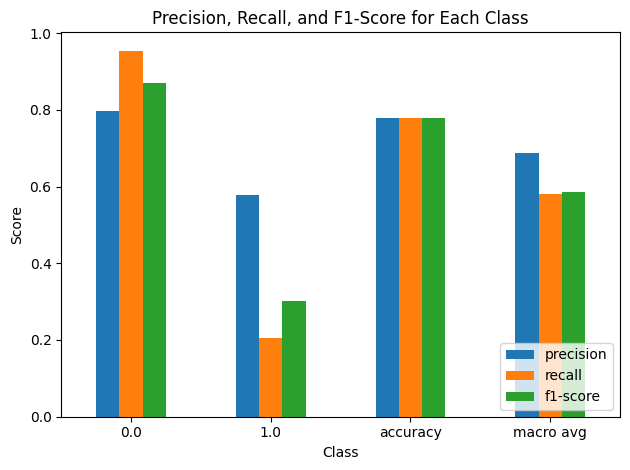

In [74]:
# Precision, Recall ve F1-Score Görselleştirme
plt.figure(figsize=(8, 6))
df_report[["precision", "recall", "f1-score"]].iloc[:-1].plot(kind="bar")
plt.title("Precision, Recall, and F1-Score for Each Class")
plt.ylabel("Score")
plt.xlabel("Class")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

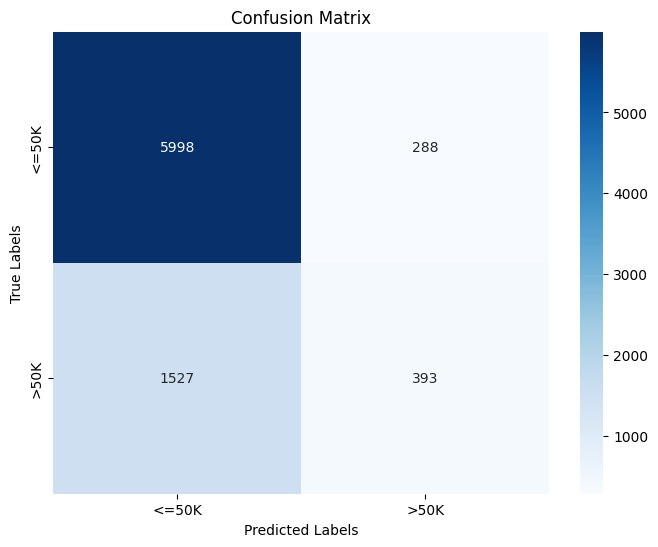

In [75]:
# Confusion Matrix
conf_matrix = confusion_matrix(predictions_pd["label"], predictions_pd["prediction"])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["<=50K", ">50K"], yticklabels=["<=50K", ">50K"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

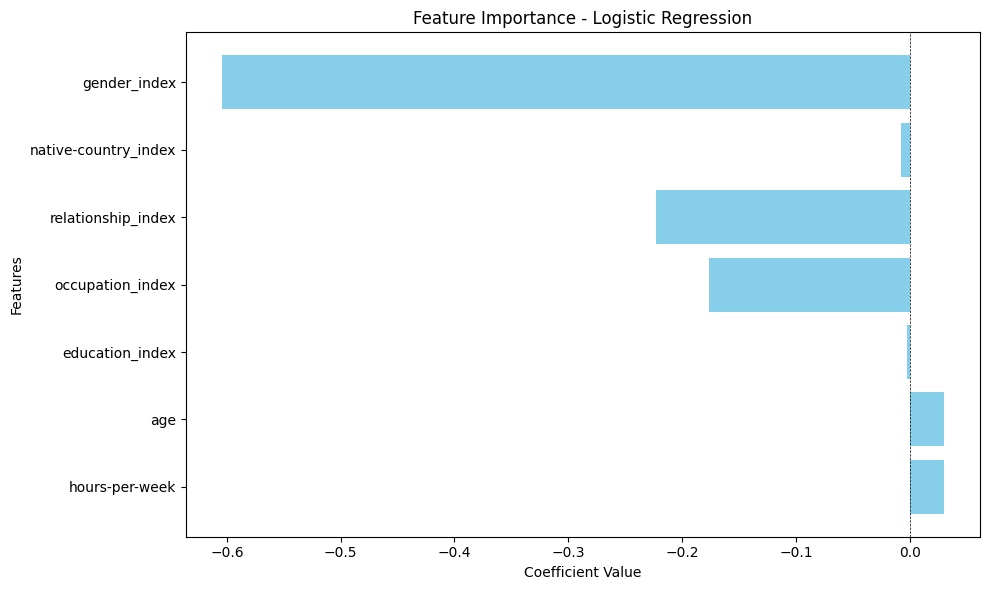

In [76]:
import numpy as np

# Logistic Regression modelini pipeline'dan al
lr_model = model.stages[-1]  # Logistic Regression aşaması
coefficients = lr_model.coefficients.toArray()  # Koefisyanları numpy array'e dönüştür
features = assembler.getInputCols()  # Özellik isimlerini al

# Feature importance'ı DataFrame'e koy
importance_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": coefficients
})


# Özellik Önem Grafiği
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Coefficient"], color='skyblue')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')  # Nötr çizgi
plt.gca().invert_yaxis()  # En önemli özelliği en üstte göstermek için
plt.title("Feature Importance - Logistic Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


### Spark ML (Random Forrest Model)

In [48]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Random Forest modeli eğit ve değerlendir
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
random_forest = RandomForestClassifier(featuresCol="features", labelCol="label", maxBins=50)
pipeline_rf = Pipeline(stages=indexers + [indexer_income, assembler, random_forest])
rf_model = pipeline_rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

rf_auc = evaluator.evaluate(rf_predictions)
print("Random Forest AUC:", rf_auc)

Random Forest AUC: 0.8433323224891293


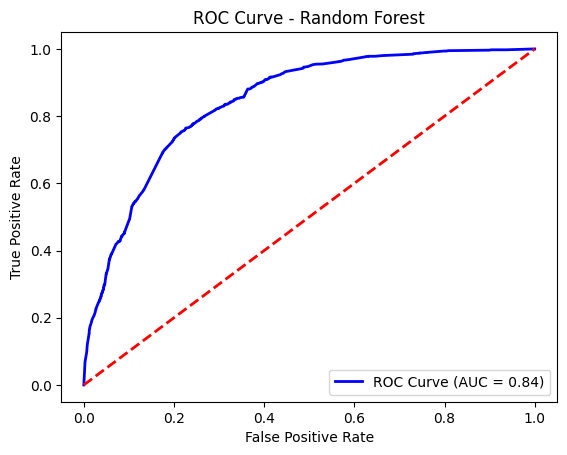

In [50]:
from sklearn.metrics import roc_curve, auc

# Tahmin edilen olasılıkları al
rf_predictions_pd = rf_predictions.select("label", "probability").toPandas()
rf_predictions_pd['probability'] = rf_predictions_pd['probability'].apply(lambda x: x[1])  # Pozitif sınıfın olasılığı

# ROC Eğrisi için true ve false positive rate'leri hesapla
fpr, tpr, thresholds = roc_curve(rf_predictions_pd['label'], rf_predictions_pd['probability'])
roc_auc = auc(fpr, tpr)

# ROC Eğrisi Çizimi
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Rastgele sınıflandırma
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

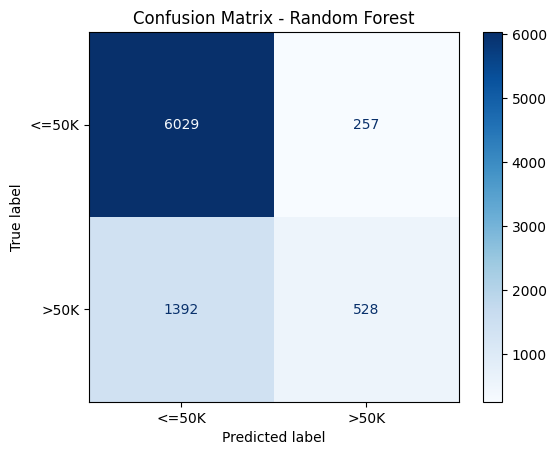

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix Hesaplama
y_true = rf_predictions_pd['label']
y_pred = rf_predictions_pd['probability'].apply(lambda x: 1 if x > 0.5 else 0)  # Threshold 0.5
cm = confusion_matrix(y_true, y_pred)

# Confusion Matrix Çizimi
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<=50K", ">50K"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest')
plt.show()

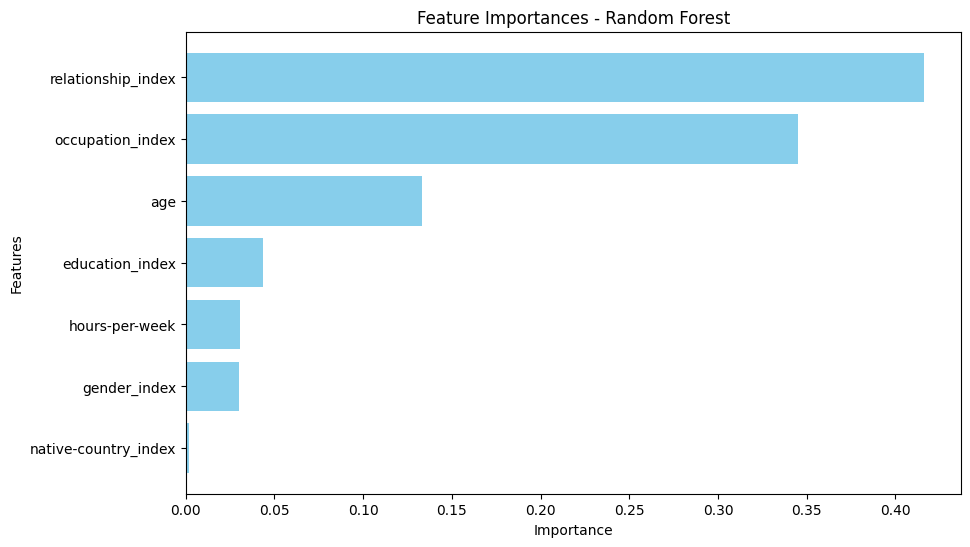

In [53]:
feature_importances = rf_model.stages[-1].featureImportances  # Random Forest modelinin son aşamasını kullan
features = assembler.getInputCols()  # Modelde kullanılan özellik isimleri
importances = pd.DataFrame({"Feature": features, "Importance": feature_importances.toArray()})
importances = importances.sort_values(by="Importance", ascending=False)

# Feature Importance Çizimi
plt.figure(figsize=(10, 6))
plt.barh(importances["Feature"], importances["Importance"], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.95      0.87      6286
         1.0       0.58      0.20      0.30      1920

    accuracy                           0.78      8206
   macro avg       0.69      0.58      0.59      8206
weighted avg       0.75      0.78      0.74      8206

Accuracy: 0.7788


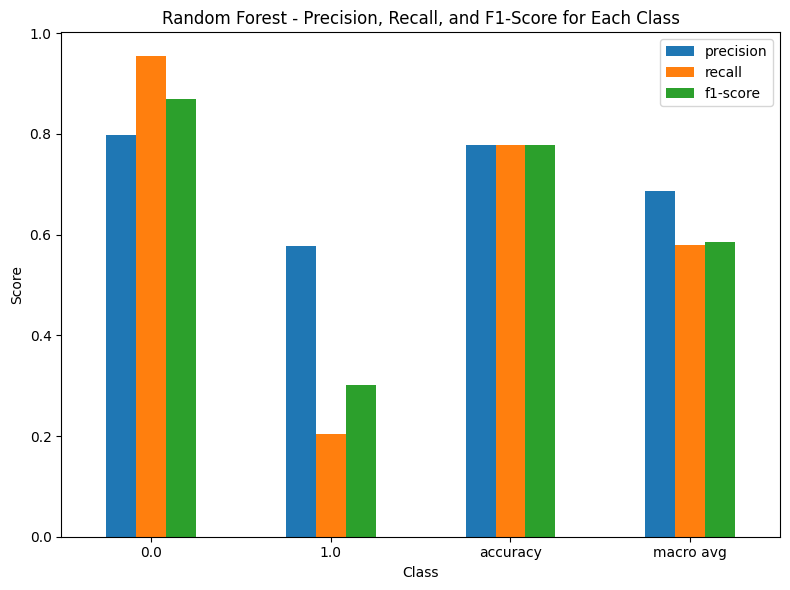

In [65]:
from sklearn.metrics import accuracy_score

# Modelin tahminlerini al
rf_predictions = model.transform(test_data)

# Spark DataFrame'den pandas'a dönüştürme
rf_predictions_pd = rf_predictions.select("label", "prediction").toPandas()

# Sınıflandırma raporunu oluştur
report_rf = classification_report(rf_predictions_pd["label"], rf_predictions_pd["prediction"], output_dict=True)

# Raporu DataFrame olarak dök
df_report_rf = pd.DataFrame(report_rf).transpose()

# Sınıflandırma raporunu yazdır
print("Random Forest Classification Report:\n", classification_report(rf_predictions_pd["label"], rf_predictions_pd["prediction"]))

# Accuracy hesaplama
accuracy_rf = accuracy_score(rf_predictions_pd["label"], rf_predictions_pd["prediction"])
print(f"Accuracy: {accuracy_rf:.4f}")

# Performans metriklerini görselleştirme
df_report_rf[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind="bar", figsize=(8, 6))
plt.title("Random Forest - Precision, Recall, and F1-Score for Each Class")
plt.ylabel("Score")
plt.xlabel("Class")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Spark SQL 

In [34]:

# DataFrame'i bir geçici SQL tablosu olarak kayıt et
final_df.createOrReplaceTempView("data")


In [35]:
print("Maaş dağılımı sayısı:")
spark.sql("""
    SELECT 
        SUM(CASE WHEN `income_>50K` == 1 THEN 1 ELSE 0 END) AS higher_than_50k,
        SUM(CASE WHEN `income_>50K` == 0 THEN 1 ELSE 0 END) AS lower_than_50k
    FROM data
""").show()

Maaş dağılımı sayısı:
+---------------+--------------+
|higher_than_50k|lower_than_50k|
+---------------+--------------+
|           9622|         31685|
+---------------+--------------+



In [49]:
print("Maaşı 50 bin dolardan yüksek olan (income_>50K = 1) mesleklerin sayısı: high_income_count")
print("Maaşı 50 bin dolardan az olan (income_>50K = 0) mesleklerin sayısı: low_income_count")
spark.sql("""
    SELECT 
        occupation,
        SUM(CASE WHEN `income_>50K` == 1 THEN 1 ELSE 0 END) AS high_income_count,
        SUM(CASE WHEN `income_>50K` == 0 THEN 1 ELSE 0 END) AS low_income_count
    FROM data
    GROUP BY occupation
""").show()

Maaşı 50 bin dolardan yüksek olan (income_>50K = 1) mesleklerin sayısı: high_income_count
Maaşı 50 bin dolardan az olan (income_>50K = 0) mesleklerin sayısı: low_income_count
+-----------------+-----------------+----------------+
|       occupation|high_income_count|low_income_count|
+-----------------+-----------------+----------------+
|            Sales|             1255|            3600|
|  Exec-managerial|             2210|            2836|
|   Prof-specialty|             2268|            2993|
|Handlers-cleaners|              137|            1602|
|  Farming-fishing|              176|            1315|
|     Craft-repair|             1011|            3402|
| Transport-moving|              683|            3930|
|  Priv-house-serv|                3|             259|
|  Protective-serv|              307|             647|
|    Other-service|              205|            4188|
|     Tech-support|              417|            1001|
|Machine-op-inspct|              312|            2159|


In [50]:
print("2000 saat ve üzeri çalışarak maaşı 50 bin dolardan yüksek veya düşük olan mesleklerde toplam çalışma saati:")
spark.sql("""
    SELECT 
        occupation,
        SUM(CASE WHEN `income_>50K` == 1 THEN `hours-per-week` ELSE 0 END) AS high_income_hours,
        SUM(CASE WHEN `income_>50K` == 0 THEN `hours-per-week` ELSE 0 END) AS low_income_hours
    FROM data
    GROUP BY occupation
    HAVING high_income_hours > 2000 OR low_income_hours > 2000
""").show()

2000 saat ve üzeri çalışarak maaşı 50 bin dolardan yüksek veya düşük olan mesleklerde toplam çalışma saati:
+-----------------+-----------------+----------------+
|       occupation|high_income_hours|low_income_hours|
+-----------------+-----------------+----------------+
|            Sales|            58035|          140759|
|  Exec-managerial|           101820|          120527|
|   Prof-specialty|           100296|          119176|
|Handlers-cleaners|             5864|           60949|
|  Farming-fishing|             9159|           58651|
|     Craft-repair|            45154|          140940|
| Transport-moving|            29311|          145978|
|  Priv-house-serv|               90|            8842|
|  Protective-serv|            13770|           26713|
|    Other-service|             8614|          149851|
|     Tech-support|            17484|           38753|
|Machine-op-inspct|            13418|           87308|
|     Adm-clerical|            26178|          140389|
+-----------

In [51]:
# native-country bazında kişilerin toplam sayısını gruplama
print("Ülke bazında kişilerin cinsiyet sayısı:")
spark.sql("""
    SELECT 
        `native-country`, 
        COUNT(*) AS total_people,
        SUM(CASE WHEN `gender` = 'Male' THEN 1 ELSE 0 END) AS total_male_count,
        SUM(CASE WHEN `gender` = 'Female' THEN 1 ELSE 0 END) AS total_female_count
    FROM data 
    GROUP BY `native-country`
""").show(45)

Ülke bazında kişilerin cinsiyet sayısı:
+--------------------+------------+----------------+------------------+
|      native-country|total_people|total_male_count|total_female_count|
+--------------------+------------+----------------+------------------+
|         Philippines|         327|             198|               129|
|             Germany|         218|             127|                91|
|            Cambodia|          30|              25|                 5|
|              France|          39|              24|                15|
|              Greece|          53|              43|                10|
|              Taiwan|          62|              43|                19|
|             Ecuador|          52|              33|                19|
|           Nicaragua|          54|              29|                25|
|                Hong|          35|              24|                11|
|                Peru|          49|              31|                18|
|               India|  

In [52]:
print("50 bin dolardan fazla maaş alan kişilerin native-country'ye göre sayısı:")
spark.sql("""
    SELECT 
        `native-country`, 
        COUNT(*) AS count_high_income
    FROM data
    WHERE `income_>50K` = 1
    GROUP BY `native-country`
    ORDER BY count_high_income DESC
""").show(45)

50 bin dolardan fazla maaş alan kişilerin native-country'ye göre sayısı:
+--------------------+-----------------+
|      native-country|count_high_income|
+--------------------+-----------------+
|       United-States|             8589|
|             Unknown|              226|
|         Philippines|               93|
|              Canada|               68|
|               India|               62|
|             Germany|               60|
|              Mexico|               55|
|             England|               47|
|               China|               41|
|                Cuba|               36|
|               Japan|               35|
|               Italy|               32|
|              Taiwan|               26|
|                Iran|               22|
|         Puerto-Rico|               21|
|               South|               19|
|              France|               18|
|              Greece|               18|
|             Jamaica|               16|
|              Poland|   

In [54]:
print("Eğitim düzeyi ve yaş arasındaki ilişki:")
spark.sql("""
    SELECT 
        education, 
        ROUND(AVG(age)) AS avg_age,
        MIN(age) AS min_age,
        MAX(age) AS max_age,
        COUNT(*) AS total_people
    FROM data
    GROUP BY education
    ORDER BY avg_age DESC
""").show()

Eğitim düzeyi ve yaş arasındaki ilişki:
+------------+-------+-------+-------+------------+
|   education|avg_age|min_age|max_age|total_people|
+------------+-------+-------+-------+------------+
|     7th-8th|   50.0|     17|     90|        1001|
|   Doctorate|   47.0|     24|     80|         578|
|     1st-4th|   46.0|     19|     90|         257|
| Prof-school|   46.0|     25|     90|         765|
|     Masters|   44.0|     18|     90|        2322|
|     5th-6th|   44.0|     17|     84|         532|
|   Preschool|   42.0|     19|     77|          87|
|         9th|   41.0|     17|     90|         788|
|     HS-grad|   40.0|     17|     90|       12139|
|   Bachelors|   40.0|     19|     90|        6536|
|        10th|   39.0|     17|     90|        1321|
|   Assoc-voc|   39.0|     19|     84|        1999|
|  Assoc-acdm|   38.0|     19|     90|        1656|
|Some-college|   37.0|     17|     90|        9015|
|        11th|   33.0|     17|     90|        1674|
|        12th|   33.0|  

In [55]:
print("50 bin dolardan fazla maaş alan 50 yaş üstü ve altı kişiler:")
spark.sql("""
    SELECT 
        CASE 
            WHEN age > 50 THEN 'Age > 50'
            ELSE 'Age <= 50'
        END AS age_group,
        COUNT(*) AS total_people
    FROM data
    WHERE `income_>50K` == 1
    GROUP BY age_group
""").show()

50 bin dolardan fazla maaş alan 50 yaş üstü ve altı kişiler:
+---------+------------+
|age_group|total_people|
+---------+------------+
| Age > 50|        2757|
|Age <= 50|        6873|
+---------+------------+

